# Forecasting With Tensorflow: Comparing Model Architectures

This notebook formulates a multi-variable forecasting problem to predict the next 9 months of Volume.

Here I compare the forecasting performance of using several different model types. Each model uses the same final two DNN layers with dropout. One of 128 units, and the final layer of 24 (the output horizon). Each of the models unique layers are:

1. A three layer DNN (one layer plus the common bottom two layers)
2. A CNN with two layers of 1D convolutions with max pooling.
3. A LSTM with two LSTM layers.
4. A CNN stacked LSTM with layers from models 2 and 3 feeding into the common DNN layer.
5. A CNN stacked LSTM with a skip connection to the common DNN layer. 

Each model is compared against baseline persistance models consisting of a one month persistence, and a three month average persistence. Also compared is the TFT error. 

# Preparing the Data

We will use tf.datasets to prepare the data. The general strategy is to clean, scale, and split the data before creating the tf.dataset object. These steps can alternatively be done within the tf.dataset itself.

***Cleaning data:*** Fill any missing values with a linear interpolation of the value. Same as done in the persistence dataset. Not needed after the check for NaN's

***Scaling data:*** In all cases the data is min max scaled.

***Features:*** As part of this simple analysis of models two feature sets are prepared. The univariate that contains sales only. The multivariate that contains sales, month, plant, material etc .

***Best Practice Original Idea***

***Splitting data:*** 6 months of test data is put aside to evaluate all the models. The train and validation sets are created with a 23/6 split, resulting in 6 month validation samples.

***new***

***Splitting data:*** due to lack of data, 6 months of validation data is put aside to evaluate all the models. The train sets are created with 29 months.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
def clean_data(series):
    """Fills missing values. 
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
    return series_filled
        
    
def scale(X):
    mm = StandardScaler()
    X_ = np.atleast_2d(X)
    return pd.DataFrame(mm.fit(X_[:23,:]).transform(X_), X.index)

In [12]:
# Reset dataset
data = pd.read_csv("data_processed_plant_item_encoded_13_03_22.csv")

In [13]:
data = clean_data(data)

In [15]:
data['Date'] = pd.to_datetime(data['Date'])
data.drop(['Unnamed: 0'], axis=1, inplace=True)
for col in ['PlantID', 'ParentItemID']:
    data[col] = data[col].astype(str).astype("category")
data['Volume'] = data['Volume'].astype(float)
data.drop(['month'], axis=1, inplace=True)
data.drop(['index.1'], axis=1, inplace=True)
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings

In [ ]:
# # need last 29 for Validation i.e. 
# list(range(6, 35))

# # need first 29 for training 
# list(range(0, 29))


In [20]:
data.columns

Index(['index', 'ParentItemID', 'PlantID', 'Volume', 'Date', 'time_idx',
       'log_volume', 'log_ret', 'avg_volume_by_material',
       'max_volume_by_material', 'min_volume_by_material',
       'std_volume_by_material', 'avg_volume_by_plant', 'max_volume_by_plant',
       'min_volume_by_plant', 'std_volume_by_plant', 'timeseries',
       'encoding_1', 'encoding_2', 'encoding_3', 'month'],
      dtype='object')

In [21]:
# Split the Validation and Train dataset by time_index
validations = data[data['time_idx'].isin(list(range(6, 35)))]
train = data[data['time_idx'].isin(list(range(0, 29)))] # generates 0 to 28

# These are the columns to minmax scale. Currently, they are ['Volume', 'log_volume', 'log_ret', 'avg_volume_by_material',
      #  'max_volume_by_material', 'min_volume_by_material',
      #  'std_volume_by_material', 'avg_volume_by_plant', 'max_volume_by_plant',
      #  'min_volume_by_plant', 'std_volume_by_plant', 'encoding_1',
      #  'encoding_2', 'encoding_3']

cols = validations.columns[[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]]

validations[cols + '_scaled'] = validations.groupby('timeseries')[cols].apply(scale)
validations.drop(cols, axis=1, inplace=True)
validations.drop(['Date'], axis=1, inplace=True)

train[cols + '_scaled'] = train.groupby('timeseries')[cols].apply(scale)
train.drop(cols, axis=1, inplace=True)
train.drop(['Date'], axis=1, inplace=True)

# One Hot Encode everyting that is categorical or Object # train.dtypes
train = pd.get_dummies(train)
validations = pd.get_dummies(validations)

C:\Users\shav.vimelindiran\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\shav.vimelindiran\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\shav.vimelindiran\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [23]:
print("Multivarate Datasets")
print(f"Train Data Shape: {train.shape}")
print(f"Val Data Shape: {validations.shape}")
print(f"Nulls In Train {np.any(np.isnan(train))}")
print(f"Nulls In Validation {np.any(np.isnan(validations))}")

Multivarate Datasets
Train Data Shape: (303079, 1123)
Val Data Shape: (303079, 1123)
Nulls In Train False
Nulls In Validation False


In [24]:
print(f'Unique timeseries in Validation: {len(validations.timeseries.unique())}')
print(f'Unique time indexed in Validation: {len(validations.time_idx.unique())}')
print(f'number of features: {len(validations.columns) - 3}')

Unique timeseries in Validation: 10451
Unique time indexed in Validation: 29
number of features: 1120


In [26]:
print(f'Unique timeseries in Train: {len(train.timeseries.unique())}')
print(f'Unique time indexed in Train: {len(train.time_idx.unique())}')
print(f'number of features: {len(train.columns) - 3}')

Unique timeseries in Train: 10451
Unique time indexed in Train: 29
number of features: 1120


# Windowing the Dataset

Use tf.dataset to create a window dataset. This is a vector of past timesteps (n_steps) that is used to predict on a target vector of future steps (n_horizon). Below shows the output for n_steps = 29 and n_horizon = 6 and the 1000 something features. So we use the last 29 months to predict the next 6 months. 

The resulting shape for X will be (batch size, n_steps, features) and Y will be (batch size, n_horizon, features).

In [27]:
# Convert to 3d matrices 
validations_matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]
train_matr = np.array(list(train.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]

In [29]:
train_matr.shape

(10451, 29, 1120)

In [30]:
np.save('validations_matr.npy', validations_matr)
np.save('train_matr.npy', train_matr)


In [50]:
validations_matr[0, :23, 0]

array([ 3.66895388e-01,  2.04299762e+00,  1.27962433e+00,  8.48152466e-01,
       -8.94330057e-01, -8.77734985e-01, -8.94330057e-01, -8.94330057e-01,
       -8.94330057e-01, -8.94330057e-01,  1.59493069e+00,  1.80381214e-03,
        4.49870747e-01,  9.80913039e-01, -5.45833552e-01, -6.49372369e-03,
       -7.61569484e-01, -8.44544842e-01, -8.61139913e-01, -8.94330057e-01,
       -8.94330057e-01,  7.65177108e-01,  1.82726169e+00])

In [33]:
print(f"The shape of validations_matr: {validations_matr.shape}")
print(f"The shape of train_matr: {train_matr.shape}")

The shape of validations_matr: (10451, 29, 1120)
The shape of train_matr: (10451, 29, 1120)


In [4]:
def window_dataset(matr, n_steps=23, n_horizon=6, batch_size=32, shuffle_buffer=100):
    """ Create a windowed tensorflow dataset
    """
    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon # Should be 29 for us 
    
    #create the inital tensor dataset
    ds = tf.data.Dataset.from_tensor_slices(matr)

    # Shuffle
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem with x and y and then batch
    ds = ds.map(lambda x : (x[:23, :], x[-6:, 0]))
    ds = ds.batch(batch_size=batch_size, drop_remainder=True)

    #Final Check
    print(f'Num. of Batchs: {len(ds)} in {ds}')
  
    return ds


In [57]:
tf.random.set_seed(42)

train_ds = window_dataset(train_matr)

print('Example sample shapes Training')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Num. of Batchs: 326 in <BatchDataset shapes: ((32, 23, 1120), (32, 6)), types: (tf.float64, tf.float64)>
Example sample shapes Training
x =  (32, 23, 1120)
y =  (32, 6)


In [58]:
tf.random.set_seed(42)

validaiton_ds = window_dataset(validations_matr)

print('Example sample shapes Validaiton ')
for idx,(x,y) in enumerate(validaiton_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Num. of Batchs: 326 in <BatchDataset shapes: ((32, 23, 1120), (32, 6)), types: (tf.float64, tf.float64)>
Example sample shapes Validaiton 
x =  (32, 23, 1120)
y =  (32, 6)


In [60]:
tf.random.set_seed(42)

validaiton_ds = window_dataset(validations_matr)

print('Example sample shapes Validaiton ')
for idx,(x,y) in enumerate(validaiton_ds):
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Num. of Batchs: 326 in <BatchDataset shapes: ((32, 23, 1120), (32, 6)), types: (tf.float64, tf.float64)>
Example sample shapes Validaiton 
x =  [[[ 3.66895388e-01  7.24145836e-01  7.13991777e-02 ...  0.00000000e+00
    1.00000000e+00  0.00000000e+00]
  [ 2.04299762e+00  8.04311235e-01  6.96382689e-02 ...  0.00000000e+00
    0.00000000e+00  1.00000000e+00]
  [ 1.27962433e+00  7.75773854e-01 -3.3453

In [ ]:
validaiton_ds = window_dataset(validations_matr)

print('Validation')
for idx,(x,y) in enumerate(validaiton_ds):
    print(f"x: x-shape {x.numpy().shape} {x.numpy()}")
    print(f"y: y-shape {y.numpy().shape} {y.numpy()}")
    break

In [44]:
validations_matr[:, :, :2].shape

(10451, 29, 2)

In [46]:
validations_matr.shape

(10451, 29, 2)

# Dataset Loading Function

Wrap the above functions into a single function that allows us to build the dataset in the same way each time.

In [5]:
def build_dataset():
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    validations_matr = np.load('validations_matr.npy')
    train_matr  = np.load('train_matr.npy')

    # tf.random.set_seed(23)
    # data = pd.read_csv("data_processed_plant_item_encoded_13_03_22.csv")
    # data = clean_data(data)
    # print('\033[92m Dataset Loaded')

    # data['Date'] = pd.to_datetime(data['Date'])
    # data.drop(['Unnamed: 0'], axis=1, inplace=True)
    # for col in ['PlantID', 'ParentItemID']:
    #     data[col] = data[col].astype(str).astype("category")
    # data['Volume'] = data['Volume'].astype(float)
    # data.drop(['month'], axis=1, inplace=True)
    # data.drop(['index.1'], axis=1, inplace=True)
    # data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings

    # print('\033[92m Data Raw preprocessed')

    # # Split the Validation and Train dataset by time_index
    # validations = data[data['time_idx'].isin(list(range(6, 35)))]
    # train = data[data['time_idx'].isin(list(range(0, 29)))] # generates 0 to 28

    # # These are the columns to minmax scale. Currently, they are ['Volume', 'log_volume', 'log_ret', 'avg_volume_by_material',
    #     #  'max_volume_by_material', 'min_volume_by_material',
    #     #  'std_volume_by_material', 'avg_volume_by_plant', 'max_volume_by_plant',
    #     #  'min_volume_by_plant', 'std_volume_by_plant', 'encoding_1',
    #     #  'encoding_2', 'encoding_3']

    # cols = validations.columns[[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]]

    # validations[cols + '_scaled'] = validations.groupby('timeseries')[cols].apply(scale)
    # validations.drop(cols, axis=1, inplace=True)
    # validations.drop(['Date'], axis=1, inplace=True)

    # train[cols + '_scaled'] = train.groupby('timeseries')[cols].apply(scale)
    # train.drop(cols, axis=1, inplace=True)
    # train.drop(['Date'], axis=1, inplace=True)

    # # One Hot Encode everyting that is categorical or Object # train.dtypes
    # train = pd.get_dummies(train)
    # validations = pd.get_dummies(validations)

    # print('\033[92m Data has been Scaled & One Hot encoded')

    # # Convert to 3d matrices 
    # validations_matr = np.array(list(validations.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]
    # train_matr = np.array(list(train.groupby('timeseries').apply(pd.DataFrame.to_numpy)))[:,:,3:]
    
    print('\033[92m Data has been converted to 3d Matrix')

    train_ds = window_dataset(train_matr)
    print('\033[92m Train tf Dataset generated')
    
    val_ds = window_dataset(validations_matr)
    print('\033[92m Validaiton tf Dataset generated')
    
    print("Datasets:")
    print('\033[92m Train')
    print(train_ds.element_spec)
    print('\033[92m Validation')
    print(val_ds.element_spec)
    
    return train_ds, val_ds, val_ds

train_ds, val_ds, test_ds = build_dataset()

 Data has been converted to 3d Matrix
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Train tf Dataset generated
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Validaiton tf Dataset generated
Datasets:
 Train
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
 Validation
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))


In [20]:
print('Example sample shapes Training')
for idx,(x,y) in enumerate(train_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    

Example sample shapes Training
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23, 1120)
y =  (32, 6)
x =  (32, 23

In [21]:
train_ds

<BatchDataset shapes: ((32, 23, 1120), (32, 6)), types: (tf.float64, tf.float64)>

# Model Configurations

Define a set of model configurations so that we can call and run each model in the same way. The cgf_model_run dictionary will store the model, its history, and the test datasetset generated.

The default model parameters are:
- n_steps: last 29 months
- n_horizon: next 6 months
- learning rate: 3e-4

In [6]:
import keras 
class CustomCallback(keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
        # keys = list(logs.keys()) 
        # # you could do more here ...            
        # print(f"End batch {batch} of training; got log keys: {keys} and loss is {logs['loss']}")
    def on_train_batch_begin(self, batch, logs=None):
        print(logs)

In [7]:
def get_params():
    learning_rate = 3e-4
    n_steps=23
    n_horizon=6
    n_features=1120

    return n_steps, n_horizon, n_features, learning_rate

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    n_steps, n_horizon, n_features, lr = get_params()
    train_ds, val_ds, test_ds = build_dataset()

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs
    # batch_size =32 
    # callbacks=[CustomCallback()]
    )
    
    model.save(f'./exported_models/{model_name}')

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Define Each Model

## DNN
A single 128 unit layer plus the common 128 and 24 unit layyers with dropout.

In [8]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params())
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25760)             0         
                                                                 
 dense (Dense)               (None, 128)               3297408   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,314,694
Trainable params: 3,314,694
Non-trainab

## CNN
Two Conv 1D layers with 64 filters each, and kernel sizes of 6 and 3 respectively. After each Conv1D layer a maxpooling1D layer with size of 2. 

In [9]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params())
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            430144    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dropout (Dropout)           (None, 192)               0       

## LSTM
Two LSTM layers with 72 and 48 units each.

In [10]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params())
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 72)            343584    
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774    

## CNN and LSTM Stacked
Using the same layers from the CNN and LSTM model, stack the CNN as input to the pair of LSTMs.

In [11]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params())
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            430144    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

## CNN and LSTM with a skip connection
The same CNN and LSTM layers as the previous models this time with a skip connection direct to the common DNN layer.

In [12]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params())
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 23, 1120)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 18, 64)       430144      ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 9, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 64)        12352       ['max_pooling1d[0][0]']          
                                                                                          

In [13]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Train Models
Run each model for 150 epochs.

In [15]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=160)
run_model("cnn", cnn_model, model_configs, epochs=160)
run_model("lstm", lstm_model, model_configs, epochs=160)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=160)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=160)

 Data has been converted to 3d Matrix
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Train tf Dataset generated
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Validaiton tf Dataset generated
Datasets:
 Train
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
 Validation
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
Epoch 1/160
326/326 [==============================] - 6s 17ms/step - loss: 9.1249 - mae: 9.3916 - val_loss: 3.5553 - val_mae: 3.8470
Epoch 2/160
326/326 [==============================] - 5s 17ms/step - loss: 9.0400 - mae: 9.3022 - val_loss: 3.5802 - val_mae: 3.8886
Epoch 3/160
326/326 [=

 Data has been converted to 3d Matrix
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Train tf Dataset generated
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Validaiton tf Dataset generated
Datasets:
 Train
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
 Validation
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
Epoch 1/160
326/326 [==============================] - 10s 26ms/step - loss: 9.1292 - mae: 9.4009 - val_loss: 3.6074 - val_mae: 3.8976
Epoch 2/160
326/326 [==============================] - 10s 30ms/step - loss: 8.7264 - mae: 9.0038 - val_loss: 3.6097 - val_mae: 3.9108
Epoch 3/160
326/326 

INFO:tensorflow:Assets written to: ./exported_models/lstm_cnn\assets


 Data has been converted to 3d Matrix
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Train tf Dataset generated
Num. of Batchs: 326 in <BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
 Validaiton tf Dataset generated
Datasets:
 Train
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
 Validation
(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))
Epoch 1/160
326/326 [==============================] - 19s 53ms/step - loss: 9.1104 - mae: 9.3746 - val_loss: 3.5815 - val_mae: 3.8657
Epoch 2/160
326/326 [==============================] - 16s 50ms/step - loss: 8.7386 - mae: 8.9909 - val_loss: 3.5828 - val_mae: 3.8624
Epoch 3/160
326/326 

INFO:tensorflow:Assets written to: ./exported_models/lstm_skip\assets


<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>

# Evaluation of Training/Validation Results

Loss curves across the models tend to decrease. Some models show a flat validation curve while training continues to decline. Where the validation loss begins to rise, we can assume overfitting to training data. The lstm_skip also has a point around epoch 75 where the val loss stops increasing. In all cases this is a sign the models are no longer learning against the validation set. Some options to help improve this are to introduce learning rate decline, or train on longer input sequences.


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [30]:
history = model_configs['dnn']['history']
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 160, 'steps': 326}
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [36]:
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    print(f"key is {key}")
    print(f"loss is {val['history'].history['loss']}")

key is dnn
key is cnn
key is lstm
key is lstm_cnn
key is lstm_skip


Loss Curves


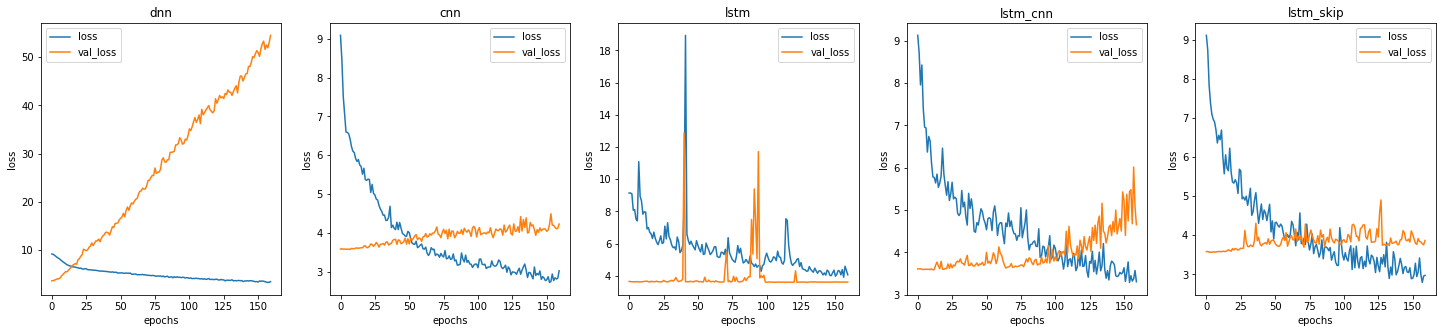

In [39]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    # ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 100)
    
print("Loss Curves")

MAE Curves


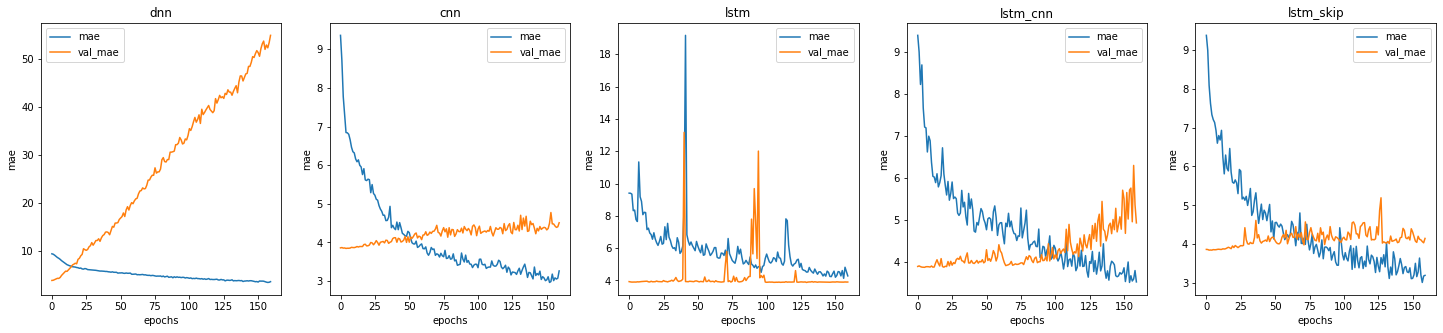

In [40]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

# Evaluation of Test Results

In [171]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    evaluation = value['model'].evaluate(value['test_ds'])
    print(f"loss: {evaluation[0]}")
    print(f"mae: {evaluation[1]}")



326/326 [==============================] - 3s 7ms/step - loss: 54.5136 - mae: 54.8270
loss: 54.51356506347656
mae: 54.827022552490234
326/326 [==============================] - 4s 11ms/step - loss: 4.2260 - mae: 4.5084
loss: 4.225959777832031
mae: 4.508408069610596
326/326 [==============================] - 6s 17ms/step - loss: 3.6090 - mae: 3.9028
loss: 3.609010696411133
mae: 3.9027743339538574
326/326 [==============================] - 5s 12ms/step - loss: 4.6509 - mae: 4.9326
loss: 4.6509222984313965
mae: 4.932595729827881
326/326 [==============================] - 6s 17ms/step - loss: 3.8656 - mae: 4.1485
loss: 3.865584373474121
mae: 4.148508548736572


# Visualizing Predictions

Plot the actual and predicted 6 month intervals. Also save the tensors for comparison metrics


In [74]:
import random

In [162]:


a = np.zeros((0,23))
b = np.random.rand(32,23)

np.concatenate((a, b), axis=0).shape

(32, 23)

In [169]:
for (key, val), ax in zip(model_configs.items(), axs):
    print(val['test_ds'])
    #10423 for num of timeseries
    x_full = np.zeros((0,23))    
    y_full = np.zeros((0,6))    

    for idx,(x,y) in enumerate(val['test_ds']):
        # print(x.numpy()[:,:,0].shape)
        x_full = np.concatenate((x_full, x.numpy()[:,:,0]), axis=0)
        # print(y.numpy().shape)
        y_full =  np.concatenate((y_full, y.numpy()), axis=0)
        

    pred = val['model'].predict(val['test_ds'])

    np.save(f'./output_matr/predictions_{key}.npy', pred)
    np.save(f'./output_matr/x_full_{key}.npy', x_full)
    np.save(f'./output_matr/y_full_{key}.npy', y_full)

<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 23, 1120), dtype=tf.float64, name=None), TensorSpec(shape=(32, 6), dtype=tf.float64, name=None))>


In [ ]:
names

['dnn', 'cnn', 'lstm', 'lstm_cnn', 'lstm_skip']

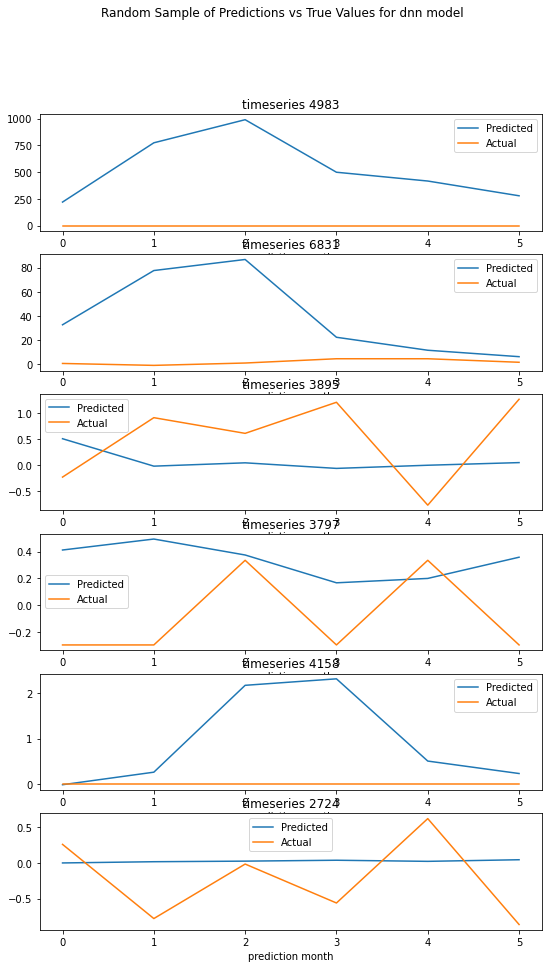

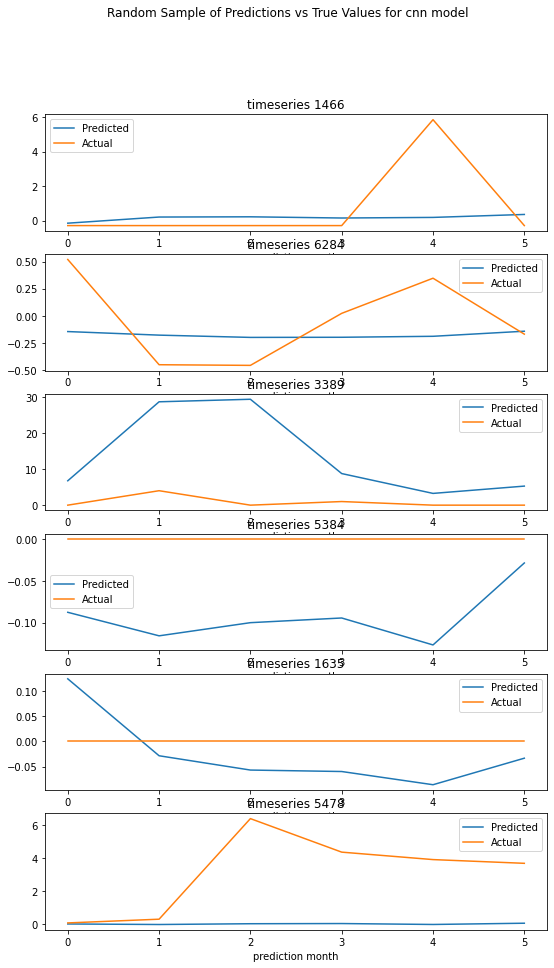

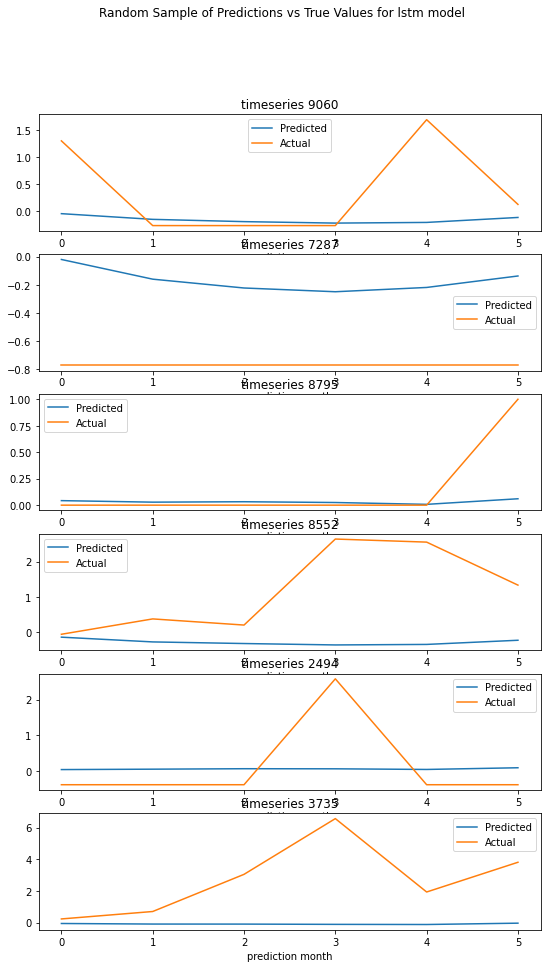

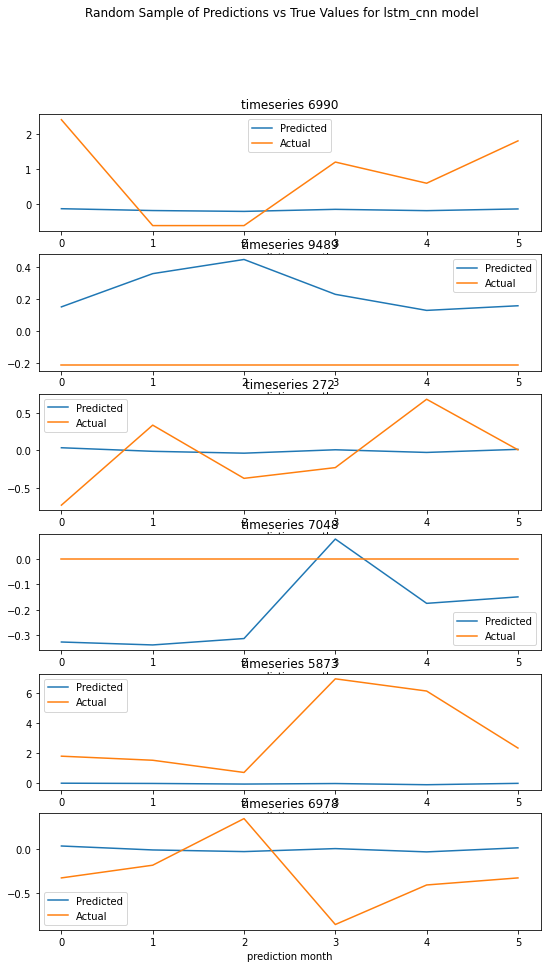

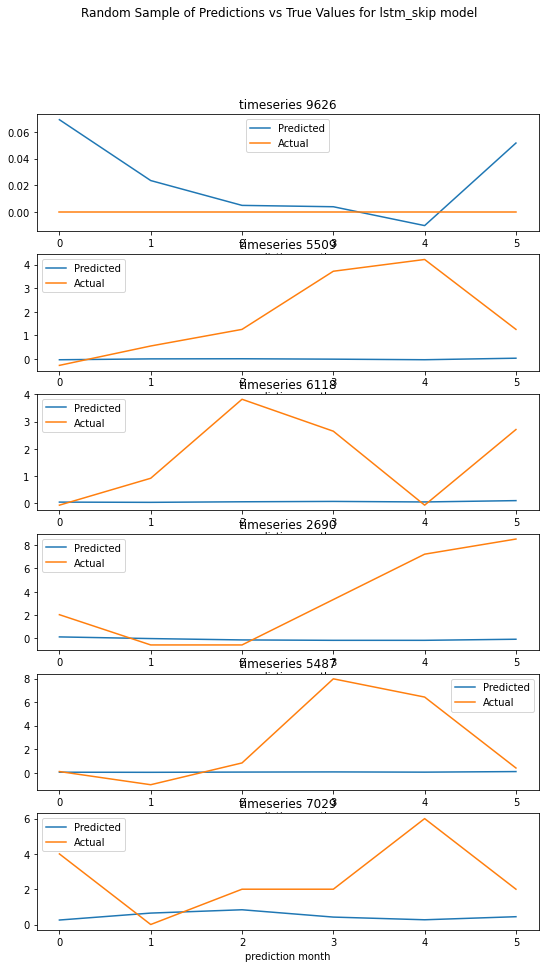

In [170]:
model_lst = ['dnn', 'cnn', 'lstm', 'lstm_cnn', 'lstm_skip']

for x in model_lst:
    y_pred = np.load(f'./output_matr/predictions_{x}.npy')
    y_true = np.load(f'./output_matr/y_full_{x}.npy')

    if y_pred.shape[0] == y_true.shape[0]:
        fig, axs = plt.subplots(6, figsize=(9, 15))
        fig.suptitle(f'Random Sample of Predictions vs True Values for {x} model')
        for x in range(6):
            random_timeseries_int = random.randint(0, y_pred.shape[0])
            axs[x].plot(y_pred[random_timeseries_int,:])
            axs[x].plot(y_true[random_timeseries_int,:])
            axs[x].set_title(f"timeseries {random_timeseries_int}")
            axs[x].legend(["Predicted", "Actual"])
            axs[x].set_xlabel("prediction month")
    else:
        print(f"Shapes do not Match. y_pred is {y_pred.shape} and y_true is {y_true.shape}  ")


In summary, doesnt look good. 